In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [21]:
cd ../src

/home/mathieu/MVA/deep-medical/pneumothorax_segmentation/src


In [23]:
from util import *
from params import *
from imports import *
from data.masks import *
from data.dataset import dicom_to_dict

In [8]:
from glob import glob
from tqdm import tqdm_notebook as tqdm

In [9]:
sns.set_style('white')
KERNEL_START_TIME = time.time()
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=RuntimeWarning)
print('Number of available cores :', multiprocessing.cpu_count())

Number of available cores : 4


In [10]:
seed_everything(seed)

# Data

In [13]:
rles_train = pd.read_csv(DATA_PATH + 'train-rle.csv')
rles_train.columns = ['ImageId', 'EncodedPixels']

print('Number of training images : ', len(rles_train))

Number of training images :  12954


In [24]:
train_files = sorted(glob(f'{TRAIN_IMG_PATH}*/*/*.dcm'))

train_metadata = []

for file_path in tqdm(train_files):
    dicom_data = pydicom.dcmread(file_path)
    train_metadata.append(dicom_to_dict(dicom_data, file_path, rles_train))

df_train = pd.DataFrame(train_metadata)

In [25]:
df_train.head(7).tail(2)

,encoded_pixels_count,file_path,has_pneumothorax,id,patient_age,patient_id,patient_name,patient_sex,pixel_spacing,rle
5,1,../input/siim/dicom-images-train/1.2.276.0.723...,False,1.2.276.0.7230010.3.1.4.8323329.10004.15178752...,45,3d911758-b2f0-4dff-8165-80c129ffa134,3d911758-b2f0-4dff-8165-80c129ffa134,F,"[0.171, 0.171]",-1
6,1,../input/siim/dicom-images-train/1.2.276.0.723...,True,1.2.276.0.7230010.3.1.4.8323329.10005.15178752...,53,bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1,bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1,F,"[0.14300000000000002, 0.14300000000000002]",209126 1 1019 6 1015 10 1012 13 1010 14 1008 1...


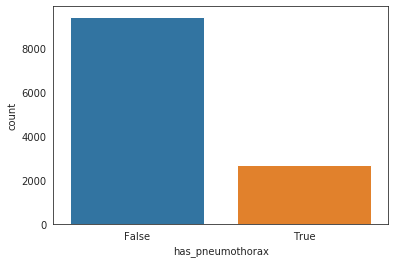

In [26]:
sns.countplot(df_train['has_pneumothorax'])
plt.show()

In [27]:
mask = rle_to_mask(df_train['rle'][6], IMG_SHAPE)
img = pydicom.dcmread(df_train['file_path'][6]).pixel_array

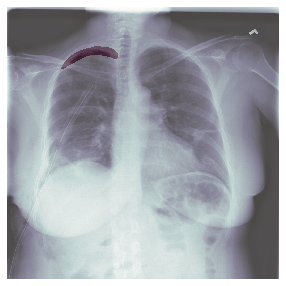

In [28]:
plot_mask(img, mask)

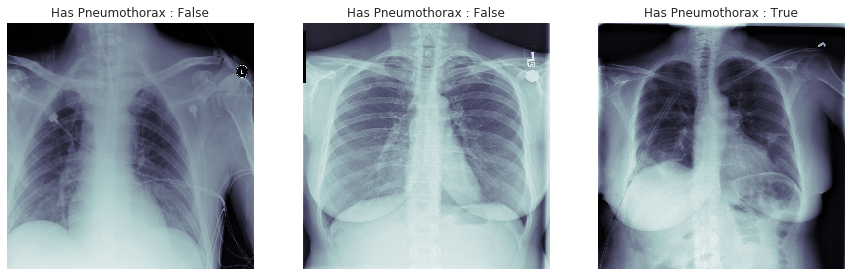

In [29]:
i = 4
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
data = pydicom.dcmread(df_train['file_path'][i])
plt.imshow(data.pixel_array, cmap=plt.cm.bone)
plt.title(f"Has Pneumothorax : {df_train['has_pneumothorax'][i]}")
plt.axis(False)
          
plt.subplot(1, 3, 2)
data = pydicom.dcmread(df_train['file_path'][i+1])
plt.imshow(data.pixel_array, cmap=plt.cm.bone)
plt.title(f"Has Pneumothorax : {df_train['has_pneumothorax'][i+1]}")
plt.axis(False)
          
plt.subplot(1, 3, 3)
data = pydicom.dcmread(df_train['file_path'][i+2])
plt.imshow(data.pixel_array, cmap=plt.cm.bone)
plt.title(f"Has Pneumothorax : {df_train['has_pneumothorax'][i+2]}")
plt.axis(False)
plt.show()

## Saving images of different resolutions to disk

In [30]:
from data.lower_res import *

In [31]:
ratio = 4

### Images

In [32]:
folder = DATA_PATH + f'train_images_{ratio}/'

if not os.path.exists(folder):
    os.mkdir(folder)

In [33]:
def lower_res(img, mask, ratio=2):
    if type(mask) == str:
        mask = rle_to_mask(mask, img.shape)

    resize = albu.Resize(IMG_SHAPE[0] // ratio, IMG_SHAPE[1] // ratio, always_apply=True)
    transformed = resize(image=img, mask=mask)

    img = transformed['image']
    mask = transformed['mask']

    rle = mask_to_rle(mask)

    return img, rle

In [34]:
resized_rles = []

for i in tqdm(range(len(df_train))):
    img = pydicom.dcmread(df_train['file_path'][i]).pixel_array
    name  = df_train['id'][i]
    mask = df_train['rle'][i]
    
    resized_img, resized_rle = lower_res(img, mask, ratio=ratio)
    
    resized_rles.append(resized_rle)
    cv2.imwrite(folder + name + '.png', resized_img)

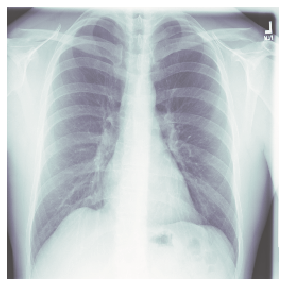

In [45]:
plot_mask(resized_img, resized_rle)

In [63]:
df_train['rle_4'] = resized_rles

In [71]:
df_train['rle_1'] = df_train['rle'].copy()

In [134]:
df_train.to_csv('../output/df_train.csv', index=False)